In [1]:
import json
import os
import pickle
import random
import sys
import pickle

from typing import Callable, Dict, List, Optional
import haiku as hk
import ase
import ase.io
import jax
import jax.numpy as jnp
import numpy as np
import optax
import yaml


from phonax.datasets import datasets
from phonax.utils import (
    create_directory_with_random_name,
    compute_avg_num_neighbors,
)
from phonax.data_utils import (
    get_atomic_number_table_from_zs,
    compute_average_E0s,
)
from phonax.predictors import predict_energy_forces_stress
from phonax.optimizer import optimizer
from phonax.energy_force_train import energy_force_train
from phonax.loss import WeightedEnergyFrocesStressLoss

from phonax.nequip_model import NequIP_JAXMD_model

from phonax.phonons import (
    predict_hessian_matrix,
    plot_bands,
    plot_phonon_DOS,
    crystal_struct_to_graph,
)

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_debug_infs", True)
np.set_printoptions(precision=3, suppress=True)

# Energy model training with energy/force data

First, we need to train the energy model using (user generated) energy / force training data.
Here we have selected the NequIP model as the base model for the energy model / interatomic potentials.


### Step 1: load the config setting file

In [2]:
with open('data/mp-149/mp149.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
        
if 'save_dir_name' in config:
    save_dir_name = config['save_dir_name']
else:
    save_dir_name = create_directory_with_random_name()
print(save_dir_name)

# Save config
with open(f"{save_dir_name}/config.yaml", "w") as f:
    yaml.dump(config, f)


2024-01-11-20:27-marxist-gwenni
2024-01-11-20:27-marxist-gwenni


### Step 2: load the energy/force training dataset

In [3]:
train_loader, valid_loader,test_loader, r_max = datasets(
    r_max = config["cutoff"],
    config_dataset = config["dataset"],
)
    
print(len(train_loader.graphs))
print(len(valid_loader.graphs))
    

nums check 1500 9000 128
Loaded 1000 training configurations from 'data/mp-149/mp-149-SC111_train.xyz'
Loaded 200 validation configurations from 'data/mp-149/mp-149-SC111_valid.xyz'
Total number of configurations: train=1000, valid=200, test=0


100%|██████████████████████████████████████| 200/200 [00:00<00:00, 24742.24it/s]
0it [00:00, ?it/s]

1000
200


### Step 3: construct and initialize the NequIP energy model

In [4]:
model_fn, params, num_message_passing = NequIP_JAXMD_model(
    r_max=r_max,
    atomic_energies_dict={},
    train_graphs=train_loader.graphs,
    initialize_seed=config["model"]["seed"],
    num_species = config["model"]["num_species"],
    use_sc = True,
    graph_net_steps = config["model"]["num_layers"],
    hidden_irreps = config["model"]["internal_irreps"],
    nonlinearities =  {'e': 'swish', 'o': 'tanh'},
    save_dir_name = save_dir_name,
    reload = config["initialization"]['reload'] if 'reload' in config["initialization"] else None,
)
    
print("num_params:", sum(p.size for p in jax.tree_util.tree_leaves(params)))
    
predictor = jax.jit(
    lambda w, g: predict_energy_forces_stress(lambda *x: model_fn(w, *x), g)
)


Compute the average number of neighbors: 27.992
Do not normalize the radial basis (avg_r_min=None)
Computed average Atomic Energies using least squares: {14: -5.531418045215}
Create NequIP (JAX-MD version) with parameters {'use_sc': True, 'graph_net_steps': 2, 'hidden_irreps': '16x0e + 16x0o +12x1e + 12x1o + 8x2e +8x2o', 'nonlinearities': {'e': 'swish', 'o': 'tanh'}, 'r_max': 5.0, 'avg_num_neighbors': 27.992, 'avg_r_min': None, 'num_species': 100, 'radial_basis': <function bessel_basis at 0x7f2d6c0a8540>, 'radial_envelope': <function soft_envelope at 0x7f2d6c0a84a0>}
num_params: 58920


### Step 4: Initialize the optimizer and the loss function

In [5]:
gradient_transform, steps_per_interval, max_num_intervals = optimizer(
    lr = config["training"]["learning_rate"],
    max_num_intervals = config["training"]["max_num_intervals"],
    steps_per_interval = config["training"]["steps_per_interval"],
)
optimizer_state = gradient_transform.init(params)
print("optimizer num_params:", sum(p.size for p in jax.tree_util.tree_leaves(optimizer_state)))
    
loss_fn = WeightedEnergyFrocesStressLoss(
    energy_weight = config["training"]["energy_weight"],
    forces_weight = config["training"]["forces_weight"],
    stress_weight = config["training"]["stress_weight"],
)
    

optimizer num_params: 176762


### Step 5: perform the energy model training

In [6]:
train_out = energy_force_train(
    predictor,
    params,
    optimizer_state,
    train_loader,
    valid_loader,
    test_loader,
    gradient_transform,
    loss_fn,
    max_num_intervals,
    steps_per_interval,
    save_dir_name,
    ema_decay = config["training"]["ema_decay"],
    patience = config["training"]["patience"],
)
    


Started training


eval_train:   0%|                                         | 0/7 [00:00<?, ?it/s]

Compiled function `model` for args:
cache size: 1


eval_train: 100%|██████████████████████████| 7/7 [00:05<00:00,  1.25it/s, n=889]


Interval 0: eval_train: loss=354.6784, mae_e_per_atom=2777.5 meV, mae_f=1523.9 meV/Å, mae_s=27.9 meV/Å³


eval_valid:   0%|                                  | 0/2 [00:00<?, ?it/s, n=127]

Compiled function `model` for args:
cache size: 2


eval_valid: 100%|██████████████████████████| 2/2 [00:05<00:00,  2.68s/it, n=200]


Interval 0: eval_valid: loss=379.4782, mae_e_per_atom=2796.8 meV, mae_f=1611.2 meV/Å, mae_s=29.8 meV/Å³


Train interval 0:   1%|▏           | 7/500 [00:07<06:25,  1.28it/s, loss=10.872]

Compiled function `update_fn` for args:
Outout: loss= 330.859
Compilation time: 7.336s, cache size: 1
Compiled function `update_fn` for args:
Outout: loss= 245.776
Compilation time: 0.018s, cache size: 2


eval_train: 100%|██████████████████████████| 7/7 [00:00<00:00, 55.04it/s, n=889]


Interval 1: eval_train: loss=0.1210, mae_e_per_atom=51.2 meV, mae_f=24.3 meV/Å, mae_s=68.4 meV/Å³


eval_valid: 100%|██████████████████████████| 2/2 [00:00<00:00, 58.43it/s, n=200]


Interval 1: eval_valid: loss=0.1356, mae_e_per_atom=51.8 meV, mae_f=23.9 meV/Å, mae_s=70.1 meV/Å³


eval_train: 100%|██████████████████████████| 7/7 [00:00<00:00, 53.14it/s, n=889]


Interval 2: eval_train: loss=0.0810, mae_e_per_atom=38.1 meV, mae_f=20.8 meV/Å, mae_s=62.6 meV/Å³


eval_valid: 100%|██████████████████████████| 2/2 [00:00<00:00, 56.31it/s, n=200]


Interval 2: eval_valid: loss=0.0871, mae_e_per_atom=38.8 meV, mae_f=20.8 meV/Å, mae_s=65.2 meV/Å³


eval_train: 100%|██████████████████████████| 7/7 [00:00<00:00, 54.88it/s, n=889]


Interval 3: eval_train: loss=0.0577, mae_e_per_atom=28.3 meV, mae_f=18.4 meV/Å, mae_s=60.0 meV/Å³


eval_valid: 100%|██████████████████████████| 2/2 [00:00<00:00, 57.73it/s, n=200]


Interval 3: eval_valid: loss=0.0633, mae_e_per_atom=28.8 meV, mae_f=18.9 meV/Å, mae_s=62.2 meV/Å³


eval_train: 100%|██████████████████████████| 7/7 [00:00<00:00, 54.97it/s, n=889]


Interval 4: eval_train: loss=0.0439, mae_e_per_atom=20.4 meV, mae_f=17.1 meV/Å, mae_s=58.6 meV/Å³


eval_valid: 100%|██████████████████████████| 2/2 [00:00<00:00, 55.21it/s, n=200]


Interval 4: eval_valid: loss=0.0465, mae_e_per_atom=20.5 meV, mae_f=17.4 meV/Å, mae_s=60.7 meV/Å³


eval_train: 100%|██████████████████████████| 7/7 [00:00<00:00, 52.20it/s, n=889]


Interval 5: eval_train: loss=0.0366, mae_e_per_atom=14.9 meV, mae_f=16.2 meV/Å, mae_s=57.4 meV/Å³


eval_valid: 100%|██████████████████████████| 2/2 [00:00<00:00, 56.14it/s, n=200]


Interval 5: eval_valid: loss=0.0405, mae_e_per_atom=14.9 meV, mae_f=17.1 meV/Å, mae_s=60.3 meV/Å³


eval_train: 100%|██████████████████████████| 7/7 [00:00<00:00, 53.57it/s, n=889]


Interval 6: eval_train: loss=0.0330, mae_e_per_atom=11.2 meV, mae_f=15.6 meV/Å, mae_s=57.2 meV/Å³


eval_valid: 100%|██████████████████████████| 2/2 [00:00<00:00, 57.37it/s, n=200]


Interval 6: eval_valid: loss=0.0376, mae_e_per_atom=11.1 meV, mae_f=16.9 meV/Å, mae_s=60.2 meV/Å³


eval_train: 100%|██████████████████████████| 7/7 [00:00<00:00, 54.23it/s, n=889]


Interval 7: eval_train: loss=0.0299, mae_e_per_atom=8.8 meV, mae_f=15.1 meV/Å, mae_s=56.6 meV/Å³


eval_valid: 100%|██████████████████████████| 2/2 [00:00<00:00, 56.19it/s, n=200]


Interval 7: eval_valid: loss=0.0354, mae_e_per_atom=8.5 meV, mae_f=16.5 meV/Å, mae_s=60.2 meV/Å³


eval_train: 100%|██████████████████████████| 7/7 [00:00<00:00, 54.87it/s, n=889]


Interval 8: eval_train: loss=0.0284, mae_e_per_atom=6.7 meV, mae_f=14.9 meV/Å, mae_s=57.1 meV/Å³


eval_valid: 100%|██████████████████████████| 2/2 [00:00<00:00, 58.14it/s, n=200]


Interval 8: eval_valid: loss=0.0340, mae_e_per_atom=6.6 meV, mae_f=16.3 meV/Å, mae_s=60.3 meV/Å³


eval_train: 100%|██████████████████████████| 7/7 [00:00<00:00, 53.73it/s, n=889]


Interval 9: eval_train: loss=0.0273, mae_e_per_atom=5.4 meV, mae_f=14.8 meV/Å, mae_s=57.0 meV/Å³


eval_valid: 100%|██████████████████████████| 2/2 [00:00<00:00, 58.31it/s, n=200]


Interval 9: eval_valid: loss=0.0326, mae_e_per_atom=5.2 meV, mae_f=16.0 meV/Å, mae_s=60.4 meV/Å³


eval_train: 100%|██████████████████████████| 7/7 [00:00<00:00, 55.39it/s, n=889]


Interval 10: eval_train: loss=0.0266, mae_e_per_atom=4.4 meV, mae_f=14.7 meV/Å, mae_s=57.1 meV/Å³


eval_valid: 100%|██████████████████████████| 2/2 [00:00<00:00, 56.48it/s, n=200]


Interval 10: eval_valid: loss=0.0316, mae_e_per_atom=4.4 meV, mae_f=15.8 meV/Å, mae_s=60.5 meV/Å³


eval_train: 100%|██████████████████████████| 7/7 [00:00<00:00, 53.48it/s, n=889]


Interval 11: eval_train: loss=0.0262, mae_e_per_atom=3.7 meV, mae_f=14.6 meV/Å, mae_s=57.1 meV/Å³


eval_valid: 100%|██████████████████████████| 2/2 [00:00<00:00, 57.98it/s, n=200]


Interval 11: eval_valid: loss=0.0307, mae_e_per_atom=3.8 meV, mae_f=15.6 meV/Å, mae_s=60.6 meV/Å³


eval_train: 100%|██████████████████████████| 7/7 [00:00<00:00, 54.60it/s, n=889]


Interval 12: eval_train: loss=0.0248, mae_e_per_atom=3.2 meV, mae_f=14.2 meV/Å, mae_s=56.6 meV/Å³


eval_valid: 100%|██████████████████████████| 2/2 [00:00<00:00, 59.75it/s, n=200]


Interval 12: eval_valid: loss=0.0300, mae_e_per_atom=3.2 meV, mae_f=15.5 meV/Å, mae_s=60.6 meV/Å³


eval_train: 100%|██████████████████████████| 7/7 [00:00<00:00, 54.28it/s, n=889]


Interval 13: eval_train: loss=0.0252, mae_e_per_atom=2.8 meV, mae_f=14.3 meV/Å, mae_s=57.2 meV/Å³


eval_valid: 100%|██████████████████████████| 2/2 [00:00<00:00, 60.16it/s, n=200]


Interval 13: eval_valid: loss=0.0294, mae_e_per_atom=2.9 meV, mae_f=15.3 meV/Å, mae_s=60.7 meV/Å³


eval_train: 100%|██████████████████████████| 7/7 [00:00<00:00, 53.00it/s, n=889]


Interval 14: eval_train: loss=0.0247, mae_e_per_atom=2.6 meV, mae_f=14.2 meV/Å, mae_s=57.0 meV/Å³


eval_valid: 100%|██████████████████████████| 2/2 [00:00<00:00, 55.44it/s, n=200]


Interval 14: eval_valid: loss=0.0288, mae_e_per_atom=2.7 meV, mae_f=15.2 meV/Å, mae_s=60.8 meV/Å³


eval_train: 100%|██████████████████████████| 7/7 [00:00<00:00, 53.92it/s, n=889]


Interval 15: eval_train: loss=0.0240, mae_e_per_atom=2.5 meV, mae_f=14.1 meV/Å, mae_s=57.0 meV/Å³


eval_valid: 100%|██████████████████████████| 2/2 [00:00<00:00, 56.35it/s, n=200]


Interval 15: eval_valid: loss=0.0284, mae_e_per_atom=2.7 meV, mae_f=15.1 meV/Å, mae_s=60.9 meV/Å³
Training complete


# Phonon prediction with the trained energy model

In [7]:
reload = save_dir_name
    
with open(reload + "/config.yaml") as f:
    reconfig = yaml.load(f, Loader=yaml.FullLoader)
    
load_model_fn, load_params, num_message_passing = NequIP_JAXMD_model(
    r_max=reconfig['cutoff'],
    atomic_energies_dict={},
    train_graphs=[],
    initialize_seed=reconfig["model"]["seed"],
    num_species=reconfig["model"]["num_species"],
    use_sc=True,
    graph_net_steps=reconfig["model"]["num_layers"],
    hidden_irreps=reconfig["model"]["internal_irreps"],
    nonlinearities={'e': 'swish', 'o': 'tanh'},
    save_dir_name=None,
    reload=reload,
)

Create NequIP (JAX-MD version) with parameters {'use_sc': True, 'graph_net_steps': 2, 'hidden_irreps': '16x0e + 16x0o +12x1e + 12x1o + 8x2e +8x2o', 'nonlinearities': {'e': 'swish', 'o': 'tanh'}, 'r_max': 5.0, 'avg_num_neighbors': 27.992, 'avg_r_min': None, 'num_species': 100, 'radial_basis': <function bessel_basis at 0x7f2d6c0a8540>, 'radial_envelope': <function soft_envelope at 0x7f2d6c0a84a0>}


In [9]:
atoms, graph = crystal_struct_to_graph('data/mp-149/mp-149.vasp', r_max, num_message_passing)

In [10]:
H = predict_hessian_matrix(load_params,load_model_fn,graph)

100%|███████████████████████████████████████| 1000/1000 [01:04<00:00, 15.59it/s]


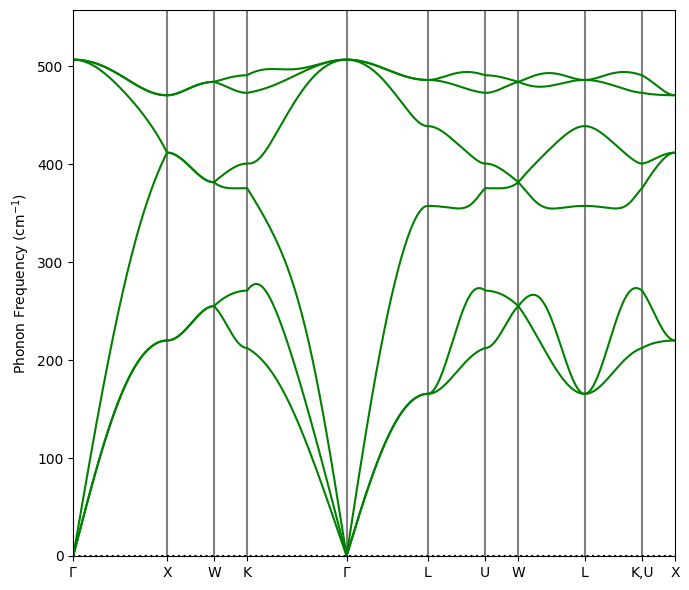

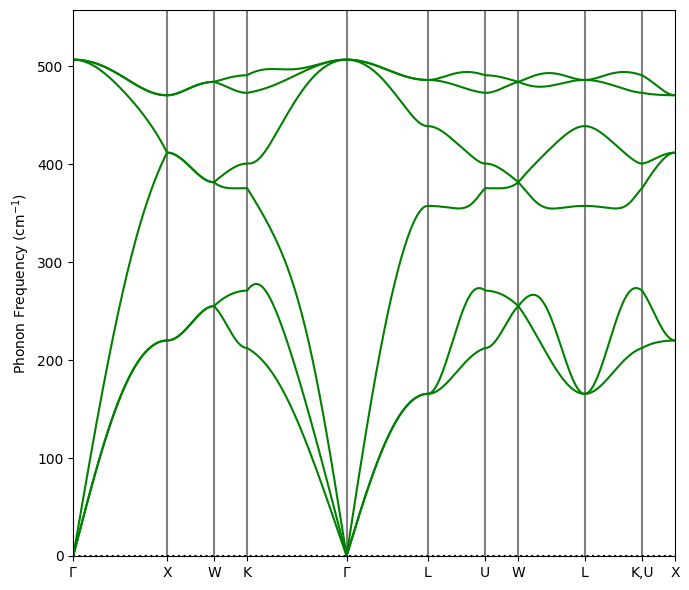

In [11]:
plot_bands(atoms, graph, H, npoints=1000)